#  Use SARIMAX to model the time series process 

# Define global variable(train_end, predict_start, predict_end) and common functions

Define train and predict windows 

In [32]:
# for development 
# train_end='2019-6'
# predict_start='2019-7'
# predict_end='2019-9'

# for final submit 
train_end='2019-9'
predict_start='2019-10'
predict_end='2019-12'

## Auto_arima Function
note the d is default at  0 and trace =True. Can turn it off or change

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [34]:
import pmdarima as pm 
def auto_arima(df,col_exog,d=0):
    try:
        results=pm.auto_arima(df[['stock_distributed']],
                              exog=df[col_exog],
                              seasonal=True,information_criterion='bic',m=12,
                          d=d, D=0, 
                          max_p=4, max_q=4, 
                          trace=True, # can turn Trace off 
                          error_action='ignore',
                          suppress_warnings=True)
        print(results.order)
        print(results.seasonal_order)
        #print(col_exog)
        return[results.order,results.seasonal_order] 
    except:
        print('error searching')

## SARIMAX - Region

It's region specific because the df_pred_agg_results_piece. The result collection part and the plot part assumes df is on regional level 

In [35]:

def predict_sarimax(df,order,seasonal_order,col_exog,plot=0):
    try:
        df_train=df[:train_end]
        df_test=df[predict_start:predict_end]
        model = SARIMAX(df_train['stock_distributed'], order=order,seasonal_order=seasonal_order,
                        exog=df_train[col_exog])
        result=model.fit()
        sarima_mean_insample=result.get_prediction(start=df_train.index[0],end=train_end,
                                                   exog=df_train[col_exog]).predicted_mean
        sarima_mean_outsample=result.get_prediction(start=predict_start,end=predict_end,
                                                    exog=df[predict_start:predict_end][col_exog]).predicted_mean
        sarima_mean_prediction=sarima_mean_insample.append(sarima_mean_outsample)
        region=df.iloc[0].region
        product_code=df.iloc[0].product_code
        
        df_pred_agg_results_piece=pd.DataFrame(data=sarima_mean_prediction,columns=['stock_distributed_forecasted'])
        df_pred_agg_results_piece['region']=region
        df_pred_agg_results_piece['product_code']=product_code 
        if plot==1:
            pd.DataFrame({'insample_pred':sarima_mean_insample,'outsample_pred':sarima_mean_outsample,'actual_value':df['stock_distributed']}).plot(); 
            plt.title(region+"--"+product_code)
            plt.show()
        return df_pred_agg_results_piece
    except:
        print('error')

# Import and process data 

## Import '../0_data/df_combined_fullsample.csv'

In [36]:
import pandas as pd
 #  contraceptive_logistics=pd.read_csv('../0_data/df_combined.csv') 
contraceptive_logistics=pd.read_csv('../0_data/df_combined_fullsample.csv')
contraceptive_logistics['day']=1
contraceptive_logistics['date']=pd.to_datetime(contraceptive_logistics[['year','month','day']])
contraceptive_logistics=contraceptive_logistics.sort_values('date')

## Aggregate on regional level 

In [37]:
col_continuous=contraceptive_logistics.columns[10:-1].to_list()
col_continuous.remove('site_type')

In [38]:
product_region_level_sum=contraceptive_logistics.groupby(['region','product_code','date'])['stock_distributed'].sum()
df_product_region_level_sum=pd.DataFrame(data=product_region_level_sum)
df_product_region_level_sum=df_product_region_level_sum.reset_index()
for col in col_continuous:
    print(col)
    df_product_region_level_sum[col]=pd.DataFrame(data=contraceptive_logistics.groupby(['region','product_code','date'])[col].mean().values)


regionasphaltroads
regionearthroads
regionsurfacetreatmentroads
regionpoorroads
poorroads
earthroads
asphaltroads
temp
maxtemp
pressure
relativehumidity
rainfallsnowmelt
visibility
windspeed
maxsustainedwindspeed
rainordrizzle
storm
fog


# SARIMAX

In [42]:
col_exog=col_continuous

### Testing - pick a random series

In [45]:
import random 
random_region=random.choice(df_product_region_level_sum['region'].unique())
df1=df_product_region_level_sum[df_product_region_level_sum['region']==random_region];
random_product_code=random.choice(df1['product_code'].unique())
df2=df1[df1['product_code']==random_product_code].copy()
len(df2)

48

In [46]:
df2['date']=pd.to_datetime(df2['date']);
df2=df2.set_index(['date']);
df2=df2.resample('MS').fillna('nearest')

GBEKE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=383.691, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=359.470, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=373.841, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=426.995, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=355.929, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=359.358, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=355.818, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=359.309, Time=0.11 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=359.062, Time=0.10 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=359.627, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=359.600, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


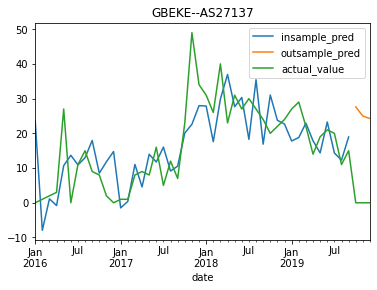

GBEKE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=355.708, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=387.033, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=354.878, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=369.323, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=418.675, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=357.244, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=352.236, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=355.994, Time=0.12 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=378.675, Time=0.19 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : BIC=350.475, Time=0.33 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=352.345, Time=0.10 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : BIC=353.754, Time=0.52 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=353.118, Time=0.14 sec
 ARIMA(3,0,0)(2,0,0)[12

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


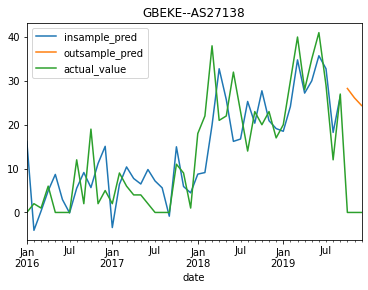

GBOKLE-NAWA-SAN PEDRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=499.528, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=485.442, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=490.417, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=561.373, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=486.210, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=487.916, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=482.561, Time=0.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=503.125, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=486.191, Time=0.22 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=486.209, Time=0.21 sec
 ARIMA(2,0,1)(0,0,1

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


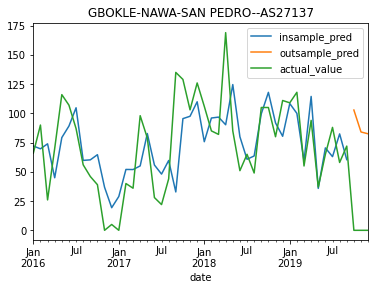

GBOKLE-NAWA-SAN PEDRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=540.134, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=542.032, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=542.676, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=560.670, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=543.686, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=543.627, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=538.804, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=541.985, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=542.376, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=542.250, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=539.612, Time=0.04 sec
 ARIMA(2,0,1)(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


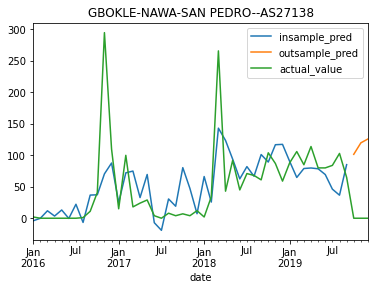

In [47]:
# testing look , plot=1 
df_pred_region_product=pd.DataFrame()
for region in df_product_region_level_sum['region'].unique()[6:8] :
    df1=df_product_region_level_sum[df_product_region_level_sum['region']==region];
    for product in df1['product_code'].unique()[6:8]:
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(region)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=1);
            # print(result_piece)
            df_pred_region_product=pd.concat([df_pred_region_product,result_piece])

## Run the full data df_pred_region_product

### Export : df_pred_region_product.to_csv('../2_pipeline/final_pred_region_lev.csv') 

In [ ]:
# run the full data , plot=1 
df_pred_region_product=pd.DataFrame()
for region in df_product_region_level_sum['region'].unique()  :
    df1=df_product_region_level_sum[df_product_region_level_sum['region']==region];
    for product in df1['product_code'].unique() :
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(region)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=0);
            # print(result_piece)
            df_pred_region_product=pd.concat([df_pred_region_product,result_piece])
df_pred_region_product.to_csv('../2_pipeline/final_pred_region_lev.csv')

# Distribute 

In [12]:
contraceptive_logistics.tail(3)

,date,site_code,product_code,year,month,stock_distributed,region,district,product_type,regionroads,...,pressure,relativehumidity,rainfallsnowmelt,visibility,windspeed,maxsustainedwindspeed,rainordrizzle,storm,fog,day
43603,2019-12-01,C3012,AS27134,2019,12,0.0,PORO-TCHOLOGO-BAGOUE,FERKESSEDOUGOU,Injectable Contraceptive,191.000000,...,1011.5000,30.20000,0.00000,5.200000,6.600000,12.700000,0.000000,0.000000,0.000000,1
42694,2019-12-01,C1701,AS27133,2019,12,0.0,AGNEBY-TIASSA-ME,TIASSALE,Injectable Contraceptive,98.000000,...,598.9047,78.26958,91.83673,8.567444,7.227927,14.248726,8.856819,8.747553,1.313337,1
44503,2019-12-01,C5076,AS46000,2019,12,0.0,KABADOUGOU-BAFING-FOLON,KORO,NaN,97.381154,...,598.9047,78.26958,91.83673,8.567444,7.227927,14.248726,8.856819,8.747553,1.313337,1


In [13]:
contraceptive_logistics['group_sum']=contraceptive_logistics.groupby(['product_code','region','date'])['stock_distributed'].transform('sum') 
contraceptive_logistics['share']=contraceptive_logistics['stock_distributed']/contraceptive_logistics['group_sum'] 
y=contraceptive_logistics.share.fillna(0)
y.shape

(44504,)

In [15]:
from sklearn.preprocessing import OneHotEncoder


In [16]:
columns_to_encode=['site_code', 'product_code', 'year', 'month',
       'region', 'district', 'product_type','site_type'] # categorical 
columns_continuous=['regionroads',
       'regionasphaltroads', 'regionearthroads', 'regionsurfacetreatmentroads',
       'regionpoorroads', 'poorroads', 'earthroads', 'asphaltroads', 'temp',
       'maxtemp', 'pressure', 'relativehumidity', 'rainfallsnowmelt',
       'visibility', 'windspeed', 'maxsustainedwindspeed', 'rainordrizzle',
       'storm', 'fog'] # continuous 

ohe = OneHotEncoder(sparse=False,categories='auto')
encoded_columns =  ohe.fit_transform(contraceptive_logistics[columns_to_encode].fillna('NA'))

 

features=pd.DataFrame(data=encoded_columns,columns=ohe.get_feature_names(columns_to_encode))
features[columns_continuous]=contraceptive_logistics[columns_continuous]

In [17]:
X=features
X.shape

(44504, 314)

## Train Test Split

In [18]:
train_end

X.index

contraceptive_logistics.shape

contraceptive_logistics.set_index('date')[:train_end].shape[0]

train_length=contraceptive_logistics.set_index('date')[:train_end].shape[0]

X_train=X[:train_length]
y_train=y[:train_length]

## Random Forest Model

In [19]:
X_train.columns[X_train.isna().any()].tolist()

[]

In [21]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=30,n_estimators=10,random_state=21)
regr.fit(X_train , y_train)
y_pred=regr.predict(X)
 

In [22]:
len(y_pred)

44504

## Export Distribute Region Level Result  ../2_pipeline/final_distribute_regionlev.csv'

In [30]:
distribute_regionlev=contraceptive_logistics[['date','region','site_code','product_code','stock_distributed']].copy()
distribute_regionlev['pred_share_regionlev']=y_pred 
distribute_regionlev['agg_level']='region'
col_export_distribute_aggregion=['date','region','site_code','product_code','pred_share_regionlev','agg_level']
distribute_regionlev[col_export_distribute_aggregion].to_csv('../2_pipeline/final_distribute_regionlev.csv')

In [29]:
len(distribute_regionlev)

44504

In [28]:
distribute_regionlev.head()

,date,region,site_code,product_code,stock_distributed,pred_share_regionlev,agg_level
14324,2016-01-01,AGNEBY-TIASSA-ME,C1098,AS27137,0.0,0.101163,region
26460,2016-01-01,BELIER,C2068,AS46000,0.0,0.119442,region
11574,2016-01-01,SUD-COMOE,C1087,AS27000,50.0,0.291504,region
34391,2016-01-01,BOUNKANI-GONTOUGO,C4018,AS27139,0.0,0.083451,region
32742,2016-01-01,BOUNKANI-GONTOUGO,C4002,AS27132,0.0,0.184091,region
